In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.special import hankel2, jv

In [2]:
def circle_coords(r: float, N:int, phi_0:float=0) -> tuple[np.ndarray]:
    phi_start = phi_0 - np.pi
    phi_stop = phi_0 + np.pi - 2*np.pi/N
    phi = np.linspace(phi_start, phi_stop, N)
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x,y

In [3]:
def inc_field(coords:tuple[np.ndarray], phi_inc:float=0) -> np.ndarray:
    x,y = coords
    return np.exp(-1j*x*np.cos(phi_inc) - 1j*y*np.sin(phi_inc))


In [4]:
def generate_A(coords_s:tuple[np.ndarray],coords_b:tuple[np.ndarray]) -> np.ndarray:
    # number of sources and boundary elements
    xs, ys = coords_s
    xb, yb = coords_b
    N = len(xs)
    M = len(xb)
    # resulting matrix
    A = np.zeros((M,N), dtype=complex)
    # for each line 
    for i in range(M):
        # coordinate of boundary element
        xi = xb[i]
        yi = yb[i]            
        r2 = (xs-xi)**2 + (ys-yi)**2
        A[i] = hankel2(0,np.sqrt(r2))
    return A

def sca_field(c:np.ndarray, coords_s:tuple[np.ndarray], coords_m:tuple[np.ndarray]) -> np.ndarray:
    xs, ys = coords_s
    xm, ym = coords_m
    N = len(xs)
    M = len(xm)
    sca = np.zeros(M, dtype=complex)  # Initialize scattered field vector
    for i in range(N):
        xi = xs[i]
        yi = ys[i]
        r2 = (xm-xi)**2 + (ym-yi)**2 
        sca += c[i]*hankel2(0,np.sqrt(r2))
    return sca

def theo_field(R_b:float, coords_m:tuple[np.ndarray],phi_inc:float = 0) -> np.ndarray:
    xm, ym = coords_m
    phim = np.arctan2(ym, xm)
    # precision of theoretical estimate
    N = 200
    M = len(xm)
    theo = np.zeros(M, dtype=complex)

    for i in np.arange(-N,N,1):
        r = np.sqrt(xm**2 + ym**2)
        c = -1j**(-i) * jv(i,R_b)/hankel2(i,R_b)
        theo += c*hankel2(i,r)*np.exp(1j*i*(phim - phi_inc))
    return theo

In [5]:
def coords2deg(coords:tuple[np.ndarray]) -> np.ndarray:
    x, y = coords
    return np.rad2deg(np.arctan2(y,x))

In [6]:
## PARAMETERS ##
# define  normalized radius of sources, boundary, measurements and mesh
R_b = 3
R_s = 0.95*R_b
R_m = 3.1
R_s *= 2*np.pi
R_b *= 2*np.pi
R_m *= 2*np.pi
# define number of points
N_s = 100
N_b = 500
N_m = 500
# define starting angle
phi_s = 0
phi_b = 0
phi_m = 0
phi_inc = 0

In [7]:
coords_s = circle_coords(R_s, N_s, phi_s)
coords_b = circle_coords(R_b, N_b, phi_b)

A = generate_A(coords_s,coords_b)
inc_b = inc_field(coords_b,phi_inc)

# solve problem
c, residuals, _, _ = np.linalg.lstsq(A, -inc_b, rcond=0.01)

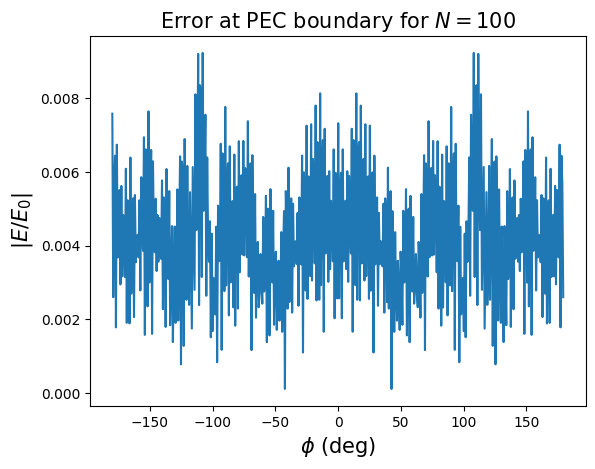

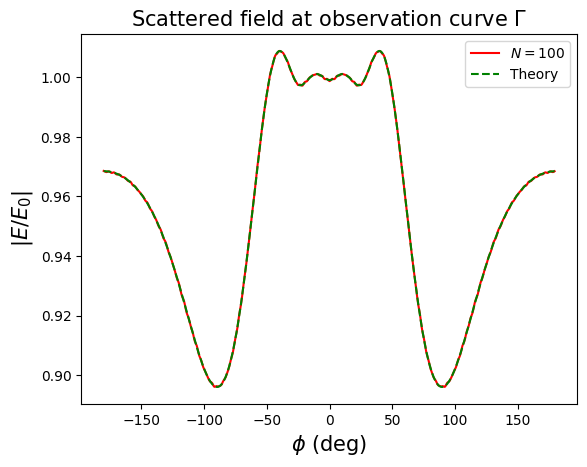

In [8]:
coords_m = circle_coords(R_m, N_m, phi_m)
sca_b = sca_field(c,coords_s,coords_b)
angles = coords2deg(coords_b)

plt.plot(angles,np.abs(sca_b + inc_b))
plt.title(r'Error at PEC boundary for $N = 100$', fontsize=15)
plt.xlabel(r'$\phi$ (deg)', fontsize=15)
plt.ylabel(r'$|E/E_0|$', fontsize=15)
plt.show()


sca_m = sca_field(c,coords_s,coords_m)
theo_m = theo_field(R_b,coords_m,phi_inc)
angles = coords2deg(coords_m)

plt.plot(angles,np.abs(sca_m),'r')
plt.plot(angles,np.abs(theo_m),'g--')
plt.title(r'Scattered field at observation curve $\Gamma$', fontsize=15)
plt.xlabel(r'$\phi$ (deg)', fontsize=15)
plt.ylabel(r'$|E/E_0|$', fontsize=15)
plt.legend([r'$N = 100$',r'Theory'])
plt.show()

In [9]:

## parameter swipe of N##
es = []
ks = []
values = range(1,N_b)
for n_s in values:
    coords_s = circle_coords(R_s, n_s, phi_s)
    A = generate_A(coords_s,coords_b)
    inc_b = inc_field(coords_b,phi_inc)
    c, residuals, _, _ = np.linalg.lstsq(A, -inc_b, rcond=0.01)
    sca_b = sca_field(c,coords_s,coords_b)
    es.append(np.mean(np.abs(sca_b + inc_b)))
    ks.append(np.linalg.cond(A))

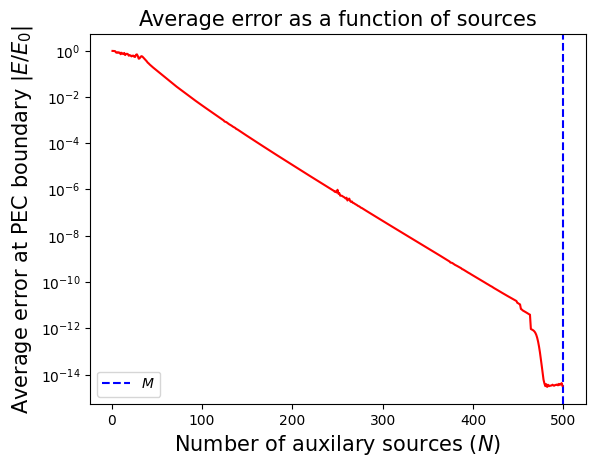

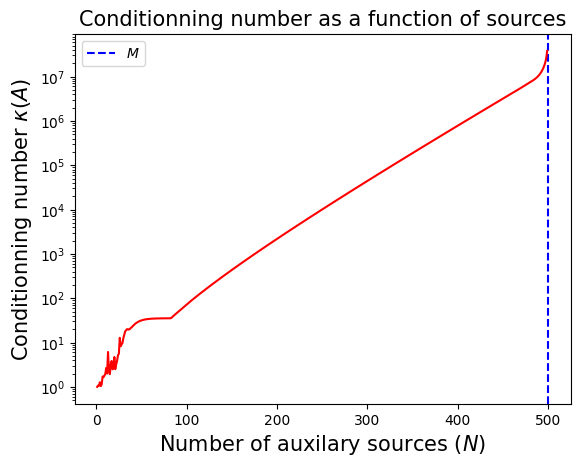

In [10]:
values = range(1,N_b)
plt.axvline(x = N_b, color='b',linestyle="--", label = r'$M$')
plt.legend()
plt.plot(values,es,'r')
plt.yscale("log")
plt.title(r'Average error as a function of sources', fontsize=15)
plt.xlabel(r'Number of auxilary sources ($N$)', fontsize=15)
plt.ylabel(r'Average error at PEC boundary $|E/E_0|$', fontsize=15)
plt.savefig("./Evaluation/E_S.pdf",bbox_inches='tight')
plt.show()

plt.axvline(x = N_b, color='b',linestyle="--", label = r'$M$')
plt.legend()
plt.plot(values,ks,'r')
plt.yscale("log")
plt.title(r'Conditionning number as a function of sources', fontsize=15)
plt.xlabel(r'Number of auxilary sources ($N$)', fontsize=15)
plt.ylabel(r'Conditionning number $\kappa (A)$', fontsize=15)
plt.savefig("./Evaluation/K_S.pdf",bbox_inches='tight')


In [11]:
## parameter swipe of M##
eb = []
kb = []
N_b_max = 500
values = range(N_s,N_b_max)
coords_s = circle_coords(R_s, N_s, phi_s)

for n_b in values:    
    coords_b = circle_coords(R_b, n_b, phi_b)
    A = generate_A(coords_s,coords_b)
    inc_b = inc_field(coords_b,phi_inc)
    c, residuals, _, _ = np.linalg.lstsq(A, -inc_b, rcond=0.01)
    sca_b = sca_field(c,coords_s,coords_b)
    eb.append(np.mean(np.abs(sca_b + inc_b)))
    kb.append(np.linalg.cond(A))


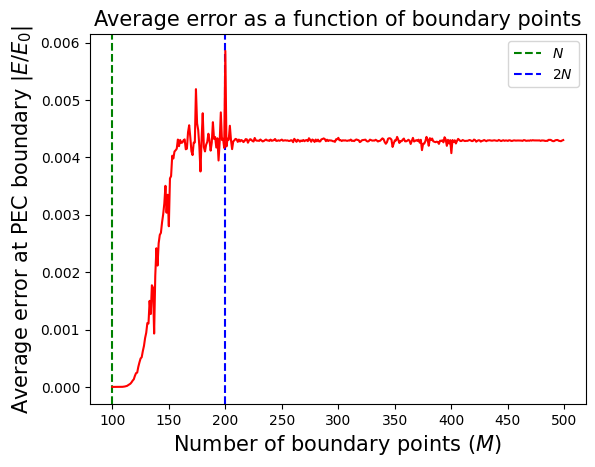

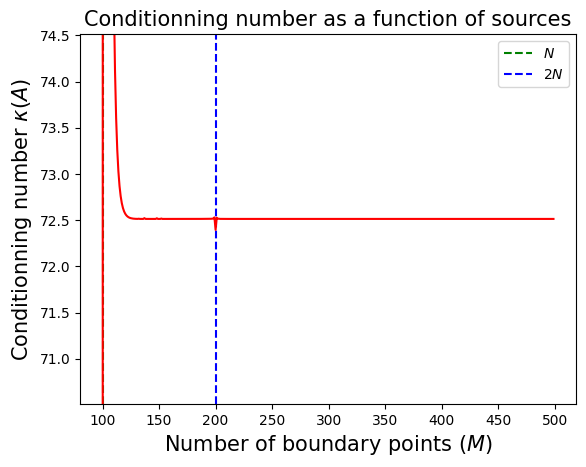

In [12]:
values = range(N_s,N_b_max)
plt.axvline(x = N_s, color='g',linestyle="--", label = r'$N$')
plt.axvline(x = 2*N_s, color='b',linestyle="--", label = r'$2N$')
plt.legend()

plt.title(r'Average error as a function of boundary points', fontsize=15)
plt.xlabel(r'Number of boundary points ($M$)', fontsize=15)
plt.ylabel(r'Average error at PEC boundary $|E/E_0|$', fontsize=15)
plt.plot(values,eb,'r')
plt.savefig("./Evaluation/E_B.pdf",bbox_inches='tight')
plt.show()


plt.axvline(x = N_s, color='g',linestyle="--", label = r'$N$')
plt.axvline(x = 2*N_s, color='b',linestyle="--", label = r'$2N$')
plt.legend()

plt.plot(values,kb,'r')
#plt.yscale("log")
plt.title(r'Conditionning number as a function of sources', fontsize=15)
plt.xlabel(r'Number of boundary points ($M$)', fontsize=15)
plt.ylabel(r'Conditionning number $\kappa (A)$', fontsize=15)
plt.ylim((kb[-1]-2,kb[-1]+2))
plt.savefig("./Evaluation/K_B.pdf",bbox_inches='tight')


In [13]:
## parameter swipe of R_s##
er = []
kr = []
N_test = 1000
values = np.linspace(0,R_b,N_test)[:-1]
coords_b = circle_coords(R_b, N_b, phi_b)
for r_s in values:
    coords_s = circle_coords(r_s, N_s, phi_s) 
    A = generate_A(coords_s,coords_b)
    inc_b = inc_field(coords_b,phi_inc)
    c, residuals, _, _ = np.linalg.lstsq(A, -inc_b, rcond=0.01)
    sca_b = sca_field(c,coords_s,coords_b)
    er.append(np.mean(np.abs(sca_b + inc_b)))
    kr.append(np.linalg.cond(A))


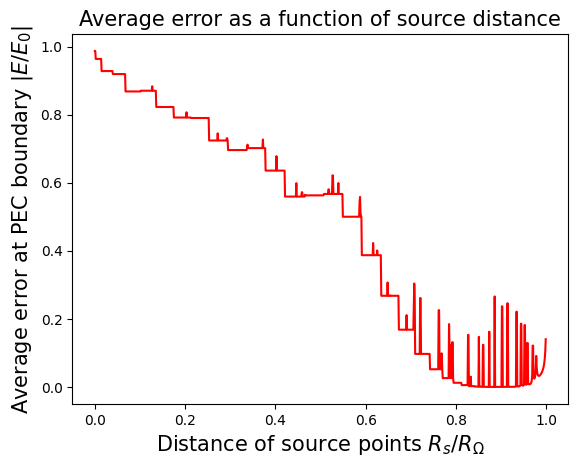

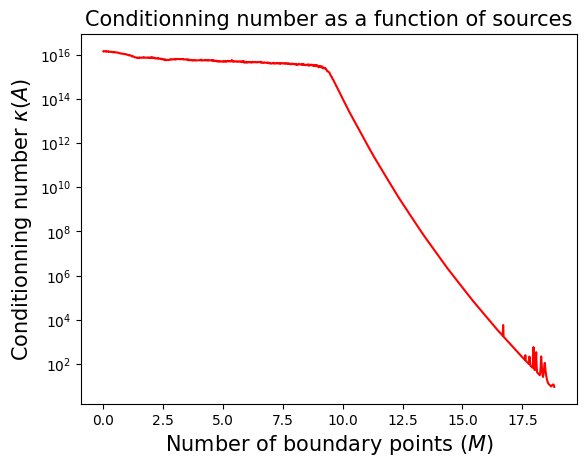

In [14]:
values = np.linspace(0,R_b,N_test)[:-1]

plt.title(r'Average error as a function of source distance', fontsize=15)
plt.xlabel(r'Distance of source points $R_s/R_\Omega$', fontsize=15)
plt.ylabel(r'Average error at PEC boundary $|E/E_0|$', fontsize=15)
plt.plot(values/R_b,er,'r')
plt.savefig("./Evaluation/E_R.pdf",bbox_inches='tight')
plt.show()

plt.plot(values,kr,'r')
plt.yscale("log")
plt.title(r'Conditionning number as a function of sources', fontsize=15)
plt.xlabel(r'Number of boundary points ($M$)', fontsize=15)
plt.ylabel(r'Conditionning number $\kappa (A)$', fontsize=15)
plt.savefig("./Evaluation/K_R.pdf",bbox_inches='tight')

In [15]:
## PARAMETERS ##
# define  normalized radius of sources, boundary, measurements and mesh
R_b = 3
R_s = 0.95*R_b
R_m = 3.1
R_s *= 2*np.pi
R_b *= 2*np.pi
R_m *= 2*np.pi
# define number of points
N_s = 100
N_b = 500
N_m = 500
# define starting angle
phi_s = 0
phi_b = 0
phi_m = 0
phi_inc = 0

coords_s = circle_coords(R_s, N_s, phi_s)
coords_b = circle_coords(R_b, N_b, phi_b)

A = generate_A(coords_s,coords_b)
inc_b = inc_field(coords_b,phi_inc)

# solve problem
c, residuals, _, _ = np.linalg.lstsq(A, -inc_b, rcond=0.01)

In [16]:
## parameter swipe of R_m##
em = []
stdm = []
N_test = 100
R_m_max = R_b*1.1
values = np.linspace(R_b,R_m_max,N_test)
for r_m in values:
    coords_m = circle_coords(r_m, N_m, phi_m)
    sca_m = sca_field(c,coords_s,coords_m)
    theo_m = theo_field(R_b,coords_m,phi_inc)
    error = sca_m - theo_m

    em.append(np.mean(np.abs(error)))
    stdm.append(np.std(error))



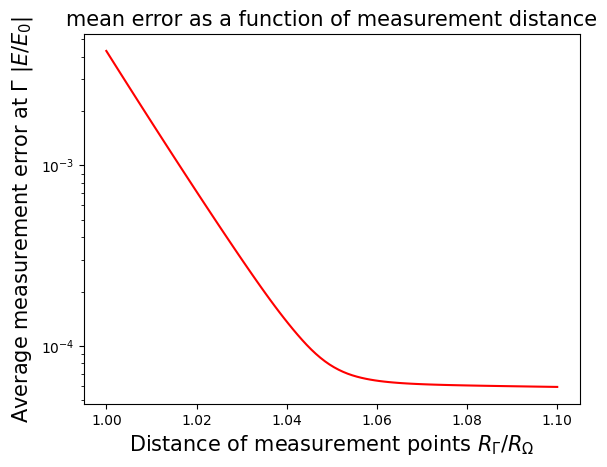

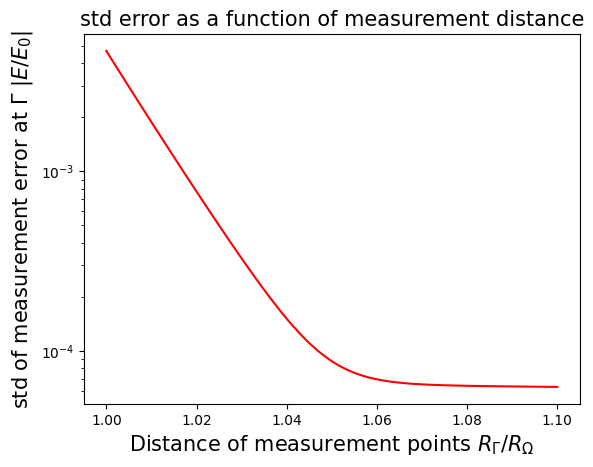

In [17]:
values = np.linspace(R_b,R_m_max,N_test)

plt.title(r'mean error as a function of measurement distance', fontsize=15)
plt.yscale("log")
plt.xlabel(r'Distance of measurement points $R_\Gamma/R_\Omega$', fontsize=15)
plt.ylabel(r'Average measurement error at $\Gamma$ $|E/E_0|$', fontsize=15)
plt.plot(values/R_b,em,'r')
plt.savefig("./Evaluation/E_G.pdf",bbox_inches='tight')
plt.show()

plt.plot(values/R_b,stdm,'r')
plt.yscale("log")
plt.title(r'std error as a function of measurement distance', fontsize=15)
plt.xlabel(r'Distance of measurement points $R_\Gamma/R_\Omega$', fontsize=15)
plt.ylabel(r'std of measurement error at $\Gamma$ $|E/E_0|$', fontsize=15)
plt.savefig("./Evaluation/STD_G.pdf",bbox_inches='tight')